Now for the fun part lets build our model!

In [5]:
! pip install scikit-optimize
#lets import our packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.tree import DecisionTreeClassifier #our first model we will try
from sklearn.ensemble import RandomForestClassifier #the other model we will try
#cross-validation
from sklearn.model_selection import cross_val_score, train_test_split
# For hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV #bayesian optimization
#to see our model's preformance 
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
#lets retrieve our features
%store -r X_train
%store -r y_train
%store -r X_test
%store -r y_test
%store -r df

In [7]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow,Humidity_Temp_Interaction,Precipitation_Bin,Pressure_Category,Temperature_Category,Wind_Speed_Category,Rain_Indicator,High_Humidity_Indicator
0,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0,6621.728203,Low,Very High,Hot,Very Windy,0,1
1,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,0,2390.593142,High,Medium,Warm,Breezy,1,0
2,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,1,5240.256547,High,Medium,Warm,Breezy,1,0
3,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,0,4665.468416,Low,Medium,Warm,Windy,1,0
4,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,0,1288.455717,High,Very High,Cold,Calm,1,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Temperature                73100 non-null  float64 
 1   Humidity                   73100 non-null  float64 
 2   Wind Speed                 73100 non-null  float64 
 3   Precipitation              73100 non-null  float64 
 4   Cloud Cover                73100 non-null  float64 
 5   Pressure                   73100 non-null  float64 
 6   Rain Tomorrow              73100 non-null  int64   
 7   Humidity_Temp_Interaction  73100 non-null  float64 
 8   Precipitation_Bin          73100 non-null  category
 9   Pressure_Category          73100 non-null  category
 10  Temperature_Category       73100 non-null  category
 11  Wind_Speed_Category        73100 non-null  category
 12  Rain_Indicator             73100 non-null  int32   
 13  High_Humidity_Indicator    7310

In [12]:
#so it seems like our model decision tree requires categorical features to be represented in numeric values
#lets do that really fast by doing dummies and split our data again

df_encoded = pd.get_dummies(df, columns=[
    'Precipitation_Bin', 
    'Pressure_Category', 
    'Temperature_Category', 
    'Wind_Speed_Category'
], drop_first=True)

df_encoded.head()

,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow,Humidity_Temp_Interaction,Rain_Indicator,High_Humidity_Indicator,Precipitation_Bin_High,Pressure_Category_Medium,Pressure_Category_High,Pressure_Category_Very High,Temperature_Category_Mild,Temperature_Category_Warm,Temperature_Category_Hot,Wind_Speed_Category_Breezy,Wind_Speed_Category_Windy,Wind_Speed_Category_Very Windy
0,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0,6621.728203,0,1,False,False,False,True,False,False,True,False,False,True
1,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,0,2390.593142,1,0,True,True,False,False,False,True,False,True,False,False
2,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,1,5240.256547,1,0,True,True,False,False,False,True,False,True,False,False
3,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,0,4665.468416,1,0,False,True,False,False,False,True,False,False,True,False
4,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,0,1288.455717,1,0,True,False,False,True,False,False,False,False,False,False


In [14]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Temperature                     73100 non-null  float64
 1   Humidity                        73100 non-null  float64
 2   Wind Speed                      73100 non-null  float64
 3   Precipitation                   73100 non-null  float64
 4   Cloud Cover                     73100 non-null  float64
 5   Pressure                        73100 non-null  float64
 6   Rain Tomorrow                   73100 non-null  int64  
 7   Humidity_Temp_Interaction       73100 non-null  float64
 8   Rain_Indicator                  73100 non-null  int32  
 9   High_Humidity_Indicator         73100 non-null  int32  
 10  Precipitation_Bin_High          73100 non-null  bool   
 11  Pressure_Category_Medium        73100 non-null  bool   
 12  Pressure_Category_High          

In [15]:
#not sure why one hot encoding gave us bool type instead of numeric lets change that
bool_columns = [
    'Precipitation_Bin_High',
    'Pressure_Category_Medium',
    'Pressure_Category_High',
    'Pressure_Category_Very High',
    'Temperature_Category_Mild',
    'Temperature_Category_Warm',
    'Temperature_Category_Hot',
    'Wind_Speed_Category_Breezy',
    'Wind_Speed_Category_Windy',
    'Wind_Speed_Category_Very Windy'
]

for col in bool_columns:
    df_encoded[col] = df_encoded[col].astype(int)
    
df_encoded.head()

,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow,Humidity_Temp_Interaction,Rain_Indicator,High_Humidity_Indicator,Precipitation_Bin_High,Pressure_Category_Medium,Pressure_Category_High,Pressure_Category_Very High,Temperature_Category_Mild,Temperature_Category_Warm,Temperature_Category_Hot,Wind_Speed_Category_Breezy,Wind_Speed_Category_Windy,Wind_Speed_Category_Very Windy
0,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0,6621.728203,0,1,0,0,0,1,0,0,1,0,0,1
1,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,0,2390.593142,1,0,1,1,0,0,0,1,0,1,0,0
2,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,1,5240.256547,1,0,1,1,0,0,0,1,0,1,0,0
3,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,0,4665.468416,1,0,0,1,0,0,0,1,0,0,1,0
4,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,0,1288.455717,1,0,1,0,0,1,0,0,0,0,0,0


In [18]:
X = df_encoded.drop(columns=['Rain Tomorrow'])
y = df_encoded['Rain Tomorrow']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.head()

,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Humidity_Temp_Interaction,Rain_Indicator,High_Humidity_Indicator,Precipitation_Bin_High,Pressure_Category_Medium,Pressure_Category_High,Pressure_Category_Very High,Temperature_Category_Mild,Temperature_Category_Warm,Temperature_Category_Hot,Wind_Speed_Category_Breezy,Wind_Speed_Category_Windy,Wind_Speed_Category_Very Windy
64233,56.823561,35.346815,0.701458,0.111800,47.107313,974.183870,2008.531911,1,0,0,0,0,0,0,0,0,0,0,0
23267,39.049845,29.564211,28.484541,0.324512,66.025724,984.209958,1154.477837,1,0,1,1,0,0,0,0,0,0,0,1
31891,73.276016,92.173726,13.041504,0.340564,39.070209,1008.532132,6754.123446,1,1,1,0,1,0,1,0,0,1,0,0
54290,31.866908,63.435624,12.229093,0.000000,82.253123,985.456910,2021.497174,0,0,0,1,0,0,0,0,0,1,0,0
2659,69.638910,66.208038,27.040636,0.546803,50.073559,992.427552,4610.655561,1,0,1,1,0,0,1,0,0,0,0,1


Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}
Accuracy: 1.0


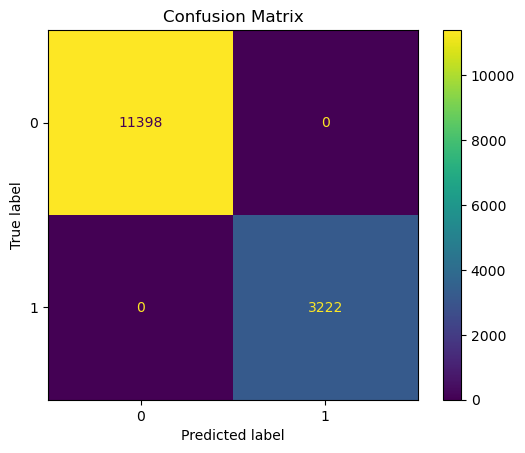

In [21]:
#lets define our model
dt = DecisionTreeClassifier()

#specifying the params we want 
param_distributions = {
    'criterion': ['gini', 'entropy'],  # Criteria to evaluate
    'max_depth': [None, 10, 20, 30],    # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],       # Minimum samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider for the best split
}

#lets use random search
random_search = RandomizedSearchCV(
    dt,
    param_distributions, # Params
    n_iter=100,  # Number of random combinations to try
    cv=5,        # Number of cross-validation folds
    random_state=42,
    n_jobs=-1    # Use all available cores
)

#Fit our Model
random_search.fit(X_train, y_train)

#the Best Model
best_dt = random_search.best_estimator_

#Predictions
y_pred = best_dt.predict(X_test)

#Performance metrics
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy)

#Confusion Matrix Visualization
ConfusionMatrixDisplay(confusion_matrix=confusion_mat).plot()
plt.title("Confusion Matrix")
plt.show()

In [22]:
#a model thats 100% accurate is highly suspicious lets get classification report and try to figure this out
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11398
           1       1.00      1.00      1.00      3222

    accuracy                           1.00     14620
   macro avg       1.00      1.00      1.00     14620
weighted avg       1.00      1.00      1.00     14620



In [23]:
#hmm lets do cross validation again 
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_dt, X_train, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0


In [24]:
#again this is concerning! lets check our df and see if we might have caused a data leakage
#if we accidently used our vector in feature engineering we might have caused a data leakage that is causing this
#problem
df_encoded.head()

,Temperature,Humidity,Wind Speed,Precipitation,Cloud Cover,Pressure,Rain Tomorrow,Humidity_Temp_Interaction,Rain_Indicator,High_Humidity_Indicator,Precipitation_Bin_High,Pressure_Category_Medium,Pressure_Category_High,Pressure_Category_Very High,Temperature_Category_Mild,Temperature_Category_Warm,Temperature_Category_Hot,Wind_Speed_Category_Breezy,Wind_Speed_Category_Windy,Wind_Speed_Category_Very Windy
0,87.524795,75.655455,28.379506,0.000000,69.617966,1026.030278,0,6621.728203,0,1,0,0,0,1,0,0,1,0,0,1
1,83.259325,28.712617,12.436433,0.526995,41.606048,995.962065,0,2390.593142,1,0,1,1,0,0,0,1,0,1,0,0
2,80.943050,64.740043,14.184831,0.916884,77.364763,980.796739,1,5240.256547,1,0,1,1,0,0,0,1,0,1,0,0
3,78.097552,59.738984,19.444029,0.094134,52.541196,979.012163,0,4665.468416,1,0,0,1,0,0,0,1,0,0,1,0
4,37.059963,34.766784,3.689661,1.361272,85.584000,1031.790859,0,1288.455717,1,0,1,0,0,1,0,0,0,0,0,0


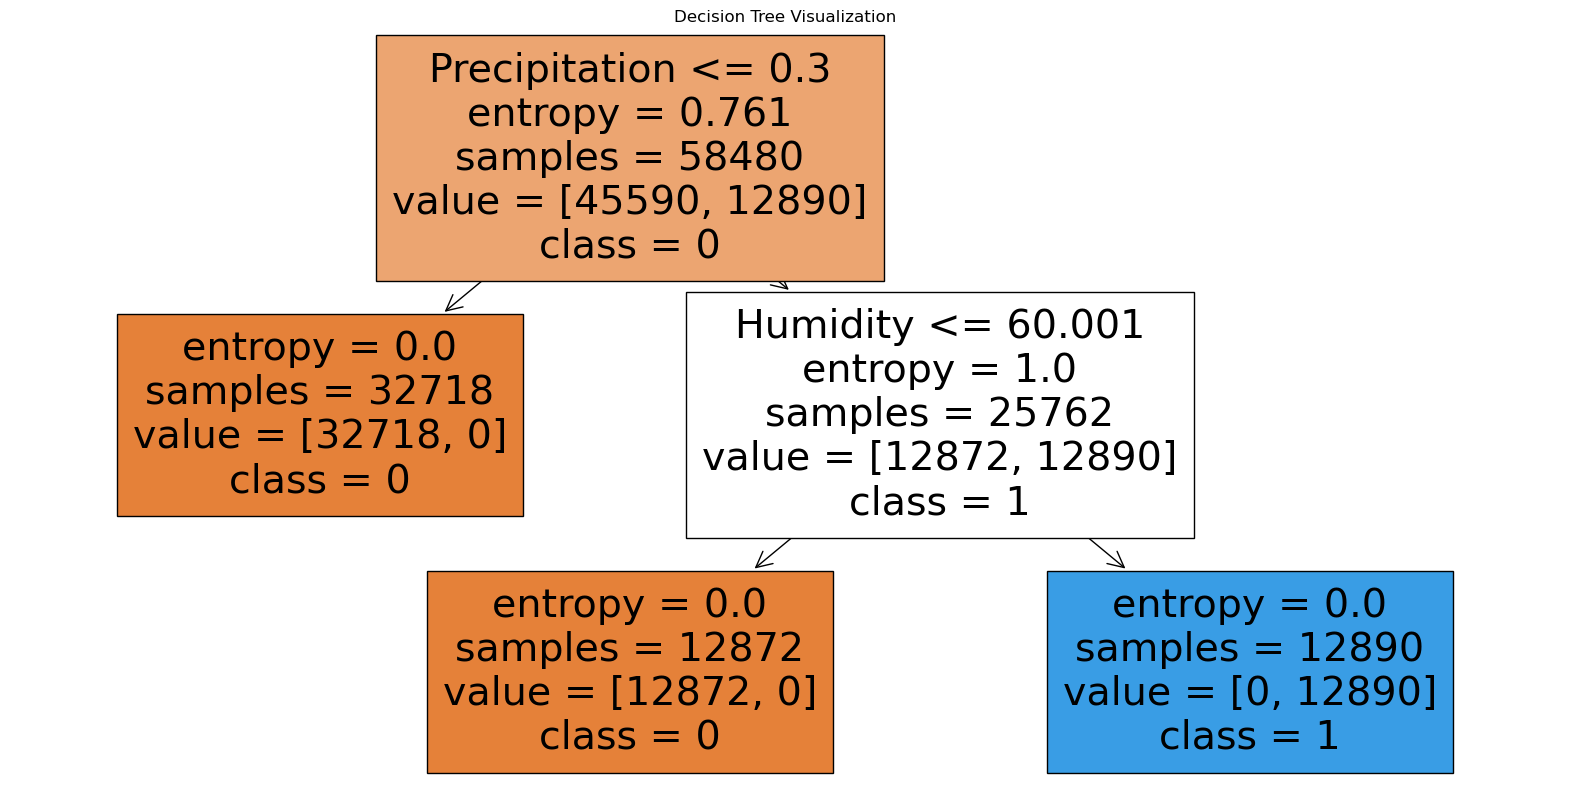

In [26]:
#after spending some time looking at our features we dont see any features that might have caused a leakage
#! our rain_indicator might sound like a data leakage but that feature only shows if any precipitation occured
#it was not taken from our vector at all.

#lets visualize our model and see if that tells us anything
from sklearn.tree import plot_tree


plt.figure(figsize=(20, 10))
plot_tree(best_dt, 
          filled=True, 
          feature_names=X_train.columns.tolist(),  # Convert to list
          class_names=['0', '1'])
plt.title("Decision Tree Visualization")
plt.show()

In [28]:
#so it looks like in the first split our entropy for no rain <= 0.3 is 0.0 which makes sense since in our 
#visualization we saw no rain under a certain value of precipitation so this is quite plausible 
#then we can see in our humidity node we see that the data is has a mix of data with entropy 1.0
#but for the leafs it seems like the model is extremely certain from the predictions 
#lets look at our data that has precipitation above 0.3 and humidity above 60.001
df_mv = df[(df["Precipitation"] > 0.3) & (df["Humidity"] > 60.001)]
df_mv["Rain Tomorrow"].unique()

array([1], dtype=int64)

In [31]:
df_mv["Rain Tomorrow"].sum()

16112

In [32]:
df["Rain Tomorrow"].sum()

16112

In [ ]:
#it looks like everything is fine so far..lets investigate further

#after going back and looking at our data split and the usage of our test and training data as well as CV
#i cant see anything thats abnormal or might have caused this it might be that our features relations 
#is just too simple for the model! 

In [ ]:
#lets try our second model and see if it does the same thing
#after doing our first model and getting a 100% i dont see that it would be of any value to do random forest here
#if our data is actually capturing all of our data we dont need a more advanced model
#so we will be doing logistic model here

In [37]:
#we will also have to standardize since logistic regression benefits from it 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#creating pipeline that has our standardscaler and our model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('log_reg', LogisticRegression())
])

#params
param_distributions = {
    'log_reg__penalty': ['l1', 'l2', 'elasticnet'],
    'log_reg__solver': ['liblinear', 'saga'], 
    'log_reg__C': [0.01, 0.1, 1, 10, 100, 1000],
    'log_reg__max_iter': [100, 200, 300, 400, 500, 600],
    'log_reg__l1_ratio': [0.0, 0.5, 1.0],
    'log_reg__class_weight': [None, 'balanced'],
}


#RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    n_iter=100,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)


random_search.fit(X_train, y_train) #fitting our data

#best preforming model
best_log_reg = random_search.best_estimator_

#results
accuracy = best_log_reg.score(X_test, y_test)
print(f'Best Parameters: {random_search.best_params_}')
print(f'Test Accuracy: {accuracy:.4f}')

C:\Users\moe\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
100 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\moe\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\moe\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\moe\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, 

Best Parameters: {'log_reg__solver': 'saga', 'log_reg__penalty': 'l2', 'log_reg__max_iter': 400, 'log_reg__l1_ratio': 0.5, 'log_reg__class_weight': 'balanced', 'log_reg__C': 100}
Test Accuracy: 0.9566


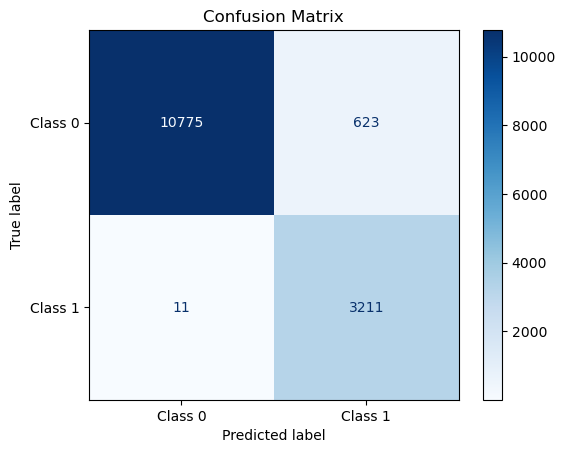

In [38]:
#the error is because some of our params dont work together which is causing the combination of params to fail

#lets look at a confusion matric
y_pred = best_log_reg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [39]:
#lets look at classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     11398
           1       0.84      1.00      0.91      3222

    accuracy                           0.96     14620
   macro avg       0.92      0.97      0.94     14620
weighted avg       0.96      0.96      0.96     14620



In [ ]:
#this looks like pretty good results! both of our models are doing well
#now we have to compare them and pick one

#Decision tree

#pros 
#very easy to visualize and has high interpretability
#has higher recall and precision

#cons 
#has too high recall and precision that we cant tell if it would be able to generalize well to future data

#logistic regression

#pros 
#reaches our desired goal which is rain recall of 80% but seems to give us a more clear look on generalization
#logistic regression is known to have more stable results and less computation time which means its more cost effective

#cons
#hard to visualize in real time because of high dimentional data

In [ ]:
#We have decided to go with logistic regression. here is why

#since both models does a great job at our task it can be a hard pick but logistic regression won
#because its stability which will make it a better choice in the long run and make it less unpredictable  with
#changes in our data. Also logistic regression is more cost effective while still reaching our desired goal
#of 80% recall.